In [70]:
#Basic libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn library
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import precision_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, median_absolute_error
from sklearn.model_selection import  cross_val_score #Hyperparameter Tuning

from statsmodels.formula.api import ols

# Random forest
from sklearn.ensemble import RandomForestRegressor

#xgboost library
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor

#lgb library
#import lightgbm as lgb
#from lightgbm import LGBMRegressor

#catboost library
from catboost import CatBoostRegressor

import optuna

import warnings
# Set global warning filter
warnings.filterwarnings("ignore")
# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*num_leaves.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*No further splits with positive gain.*")

In [2]:
df_train = pd.read_csv("data/train.csv")
df_train = df_train.drop('id', axis = 1)

target = 'Hardness'

In [3]:
df_train.columns

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

In [4]:
df_train.head()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0               100.0       0.841611                  10.0            4.8   
1               100.0       7.558488                  10.0            4.8   
2                76.0       8.885992                  15.6            5.6   
3               100.0       8.795296                  10.0            4.8   
4               116.0       9.577996                  11.6            4.8   

   atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0             20.612526           11.08810               2.766   
1             20.298893           12.04083               2.755   
2             33.739258           12.08630               2.828   
3             20.213349           10.94850               2.648   
4             24.988133           11.82448               2.766   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                  1.732                  0.860         0.496070   
1                  1.631                  0.910         0.492719   
2                  1.788                  0.864         0.481478   
3                  1.626                  0.936         0.489272   
4                  1.682                  0.896         0.492736   

   density_Average  Hardness  
0          0.91457       6.0  
1          0.71760       6.5  
2          1.50633       2.5  
3          0.78937       6.0  
4          1.86481       6.0

In [5]:
df_train.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [6]:
df_train.shape

(10407, 12)

In [7]:
num_features = df_train.select_dtypes(exclude = 'object').columns
num_features

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

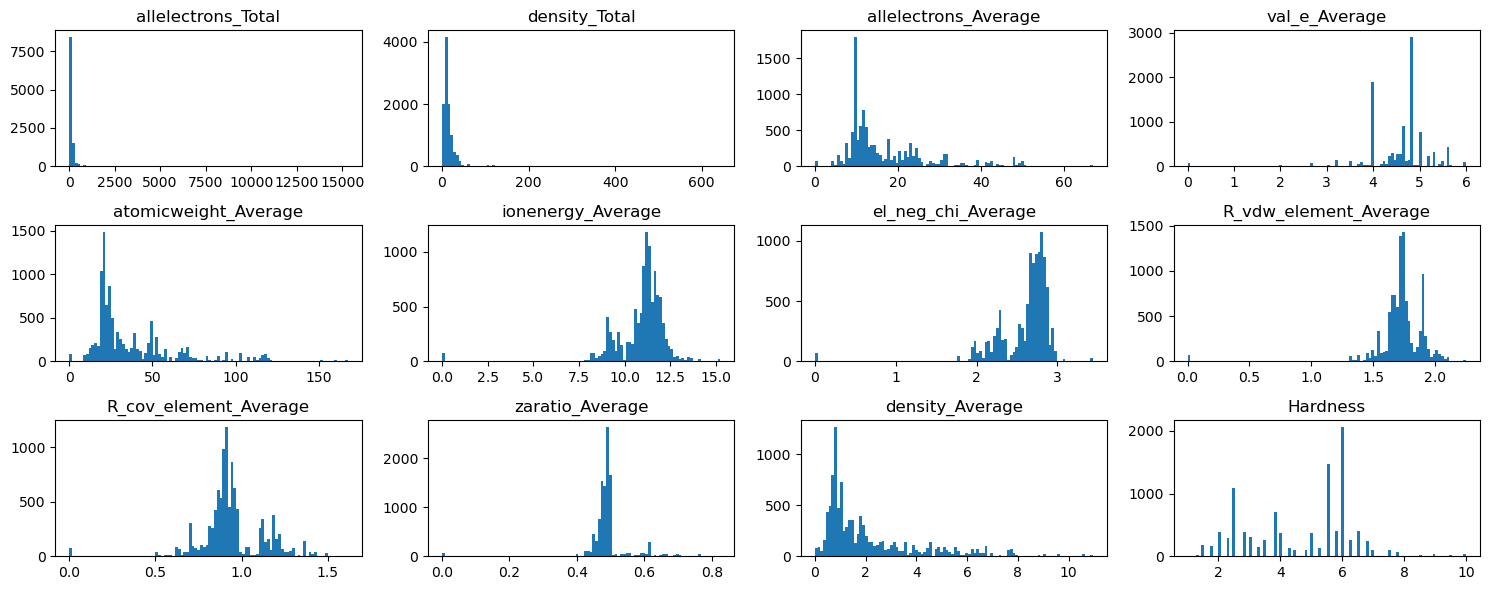

In [8]:
plt.figure(figsize = (15, 6))

for i in range(0, len(num_features)):
    plt.subplot(3, 4, i+1)
    plt.title(num_features[i])
    plt.hist(df_train[num_features[i]], bins = 100)

plt.tight_layout()

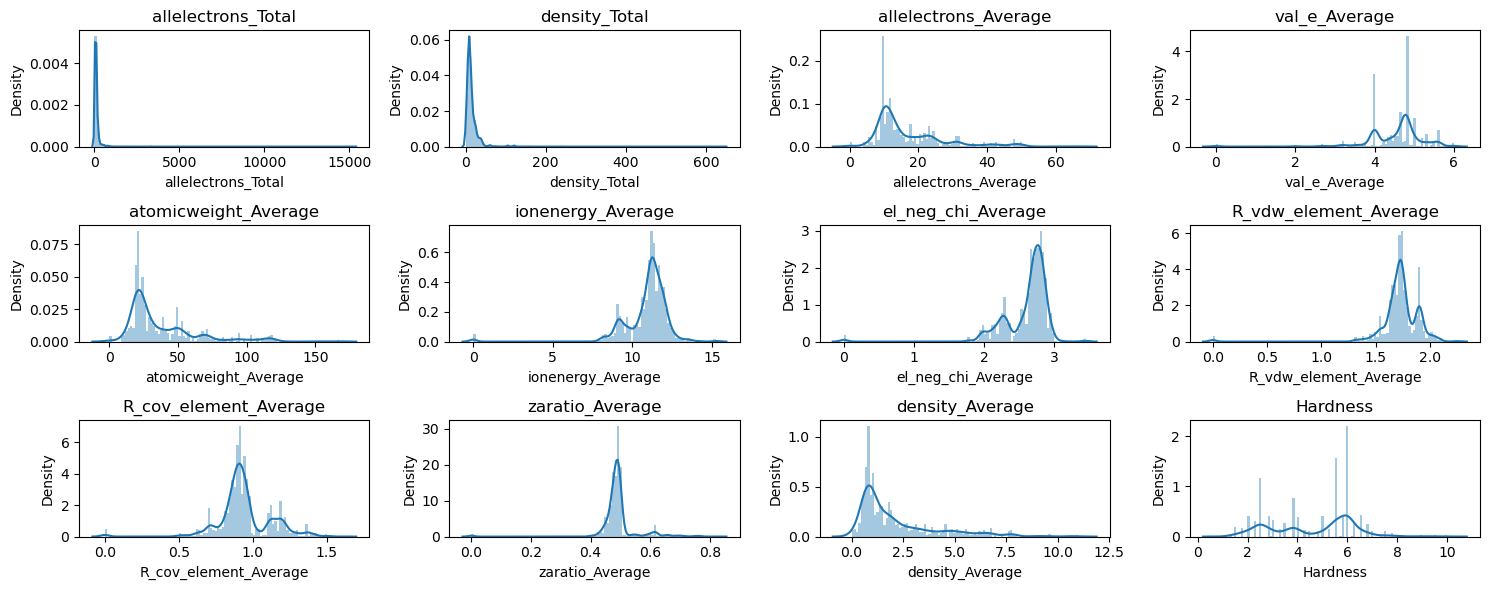

In [9]:
plt.figure(figsize = (15, 6))

for i in range(0, len(num_features)):
    plt.subplot(3, 4, i+1)
    plt.title(num_features[i])
    sns.distplot(df_train[num_features[i]], bins = 100)

plt.tight_layout()

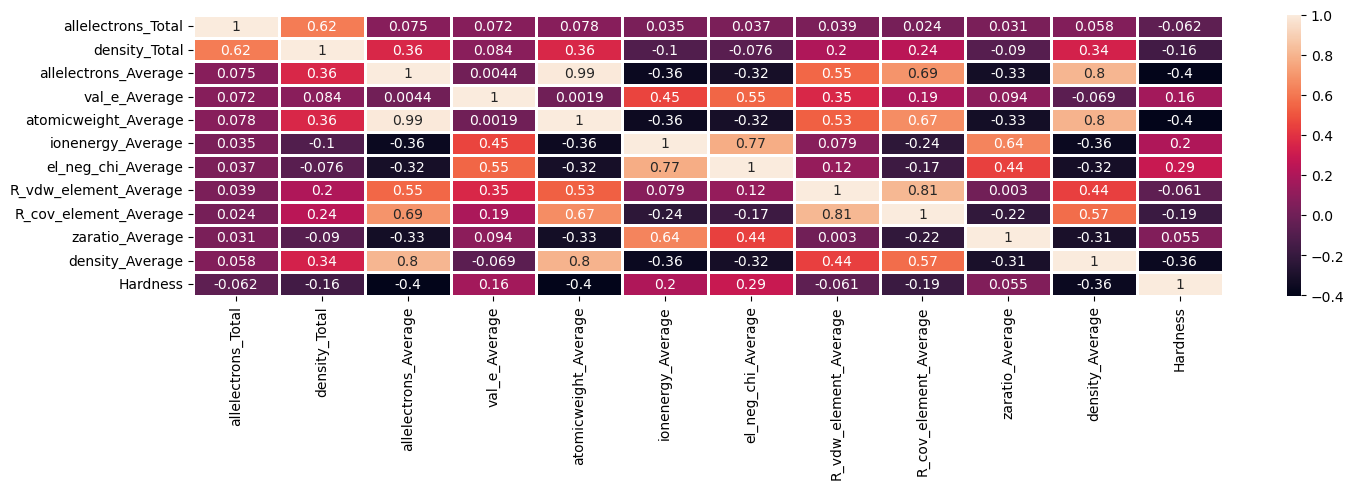

In [15]:
plt.figure(figsize = (15, 5))

sns.heatmap(df_train.corr(), annot = True, linewidths = 1)
plt.tight_layout()

<AxesSubplot:>

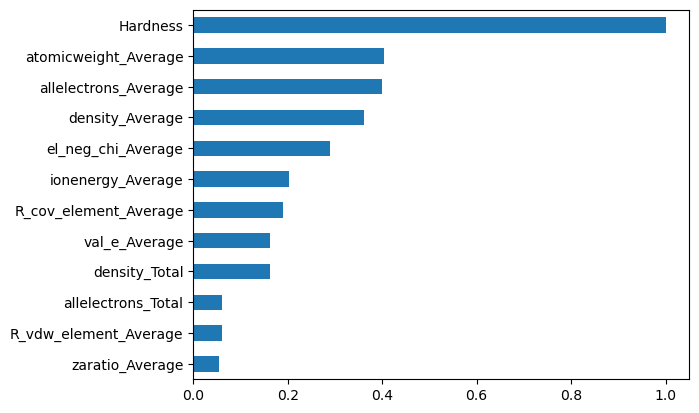

In [19]:
np.abs(df_train.corr()[target]).sort_values().plot(kind = 'barh')

In [24]:
X = df_train.drop(target, axis = 1)
y = df_train[target]

In [32]:
formula = " ~ ".join([target, " + ".join([x for x in X.columns])])
model = ols(formula = formula, data = df_train).fit()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Hardness   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     306.7
Date:                Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:48:57   Log-Likelihood:                -18706.
No. Observations:               10407   AIC:                         3.744e+04
Df Residuals:                   10395   BIC:                         3.752e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.2275      0.180     17.921      0.000       2.874       3.580
allelectrons_Total       -0.0002   8.32e-05     -2.939      0.003      -0.000   -8.14e-05
density_Total          9.326e-05      0.001      0.074      0.941      -0.002       0.003
allelectrons_Average     -0.0400      0.011     -3.762      0.000      -0.061      -0.019
val_e_Average             0.0557      0.028      1.993      0.046       0.001       0.110
atomicweight_Average     -0.0117      0.004     -2.854      0.004      -0.020      -0.004
ionenergy_Average        -0.0947      0.020     -4.811      0.000      -0.133      -0.056
el_neg_chi_Average        1.0552      0.074     14.285      0.000       0.910       1.200
R_vdw_element_Average     2.0195      0.150     13.443      0.000       1.725       2.314
R_cov_element_Average    -0.4841      0.171     -2.834      0.005      -0.819      -0.149
zaratio_Average          -4.5726      0.312    -14.649      0.000      -5.184      -3.961
density_Average          -0.0854      0.013     -6.725      0.000      -0.110      -0.060
==============================================================================
Omnibus:                       98.099   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.757
Skew:                          -0.212   Prob(JB):                     1.79e-23
Kurtosis:                       3.248   Cond. No.                     5.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

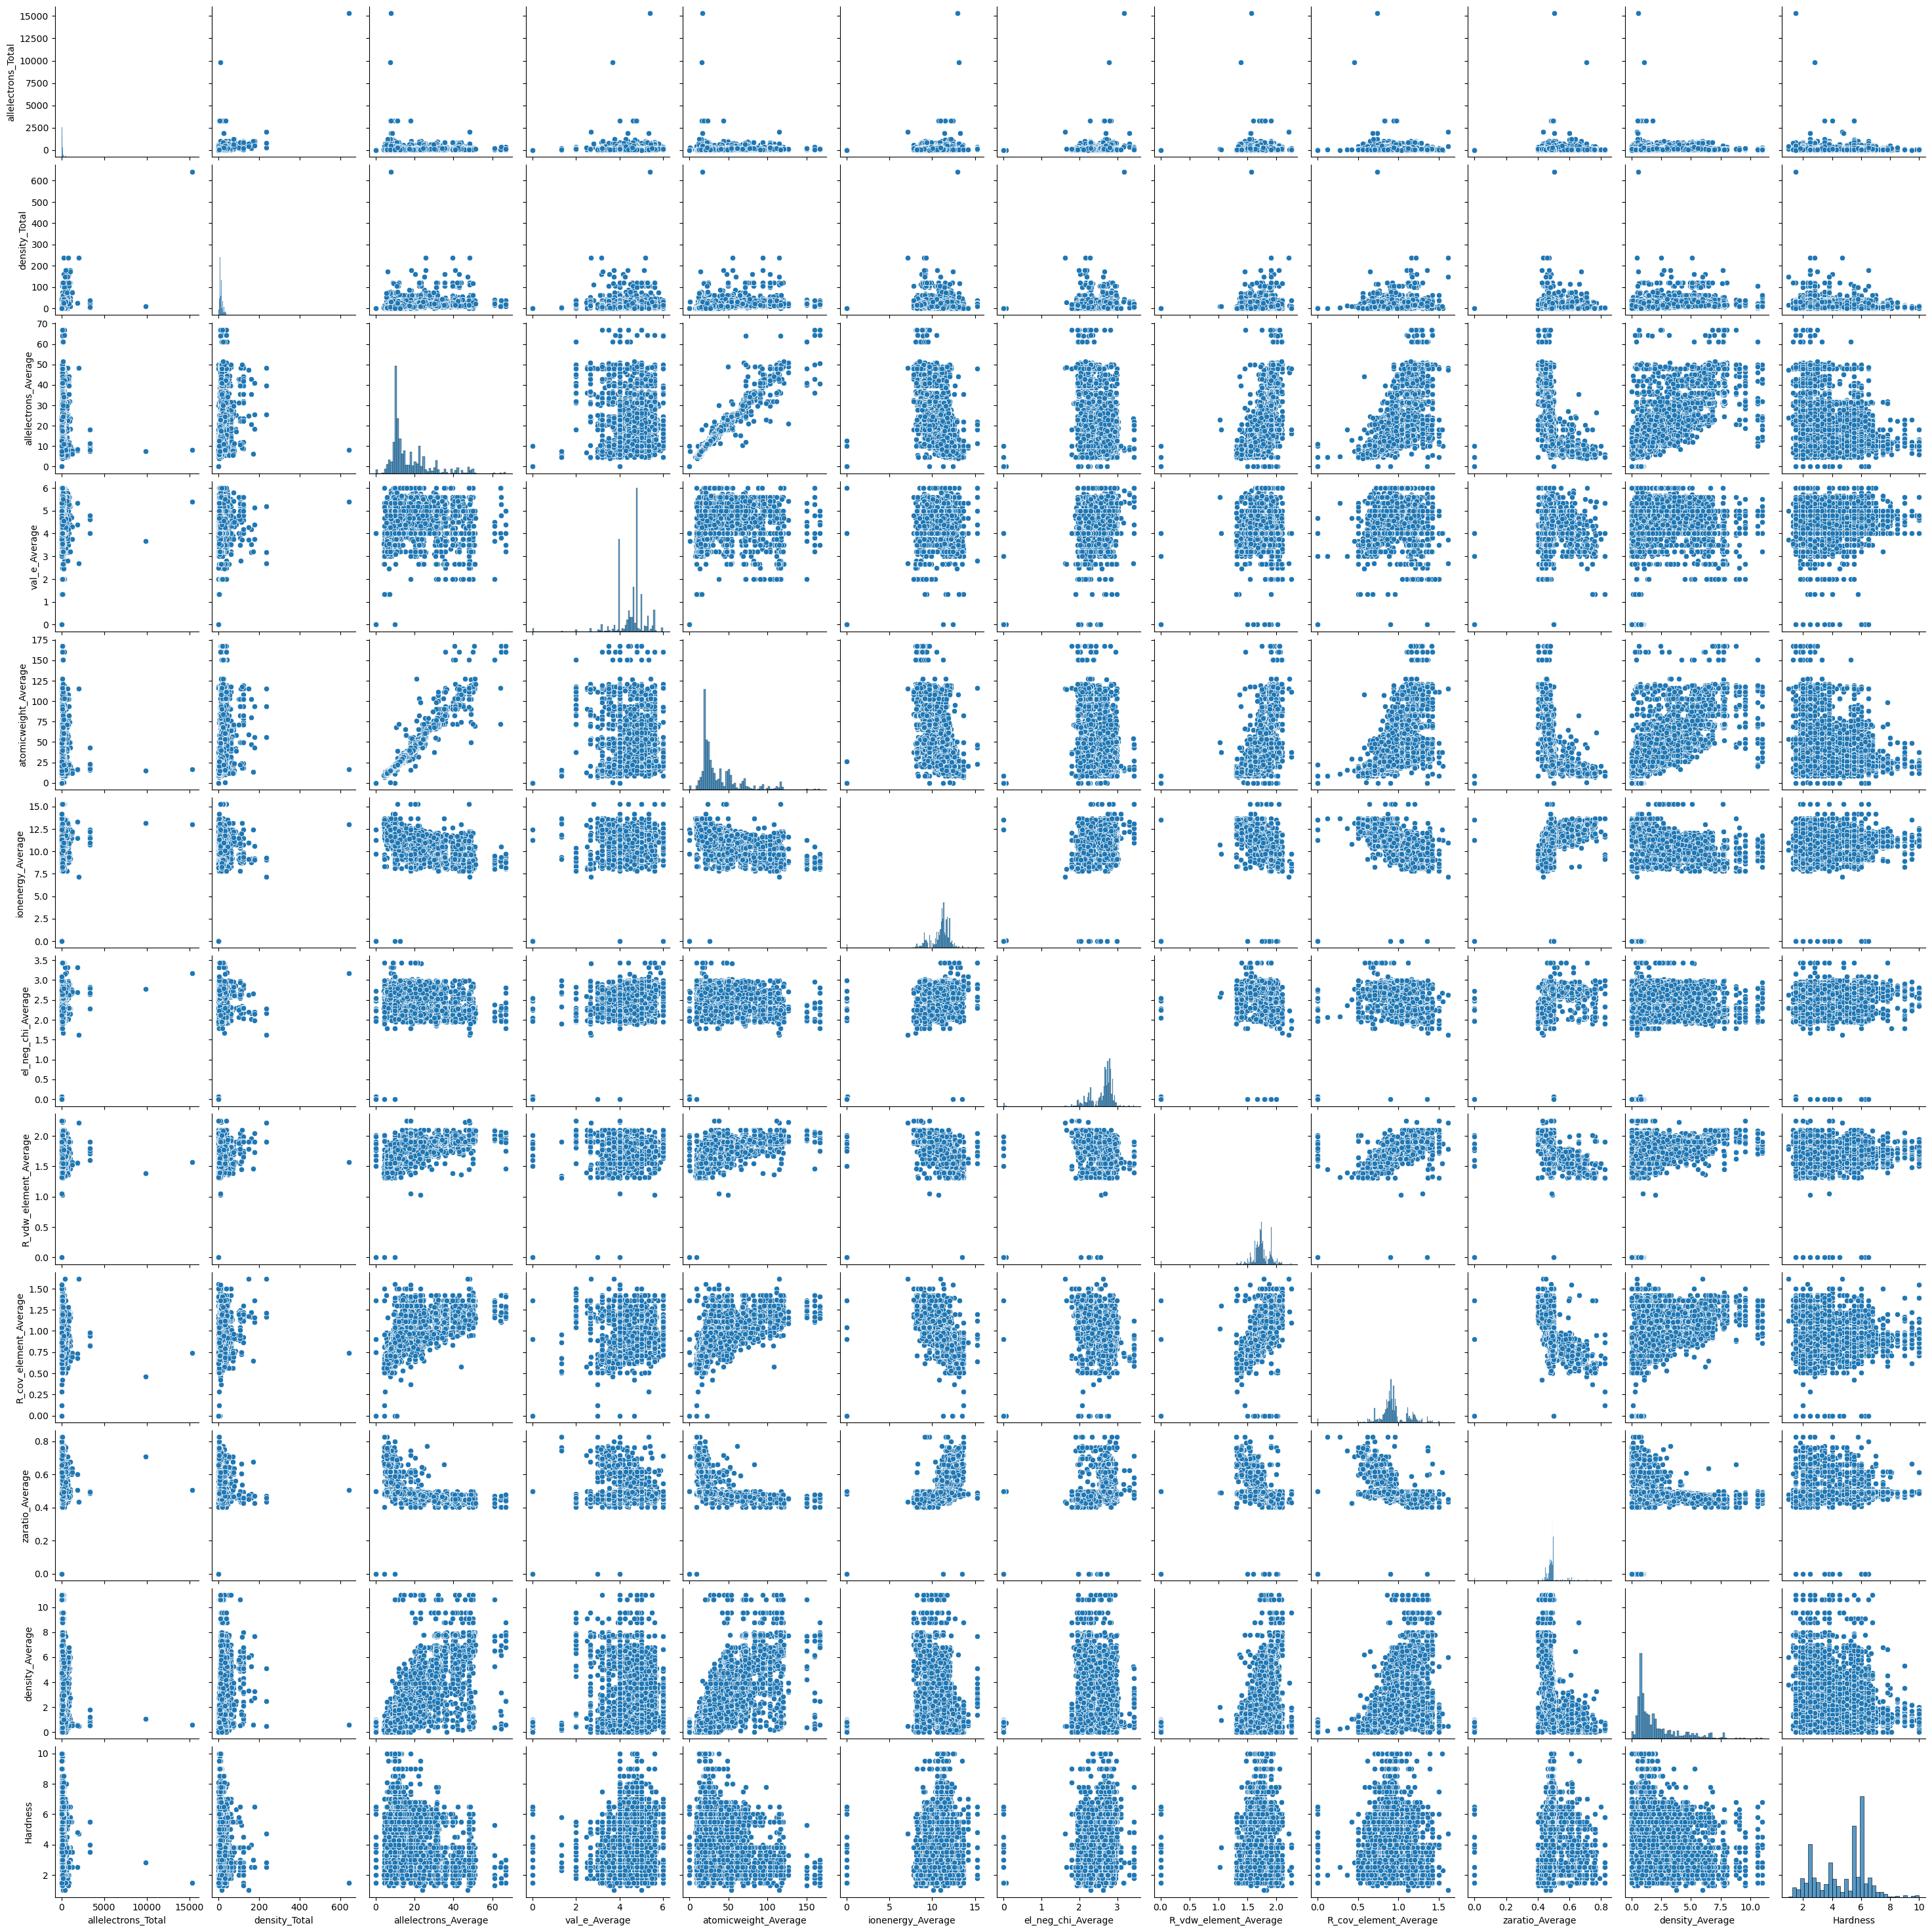

In [35]:
sns.pairplot(df_train)

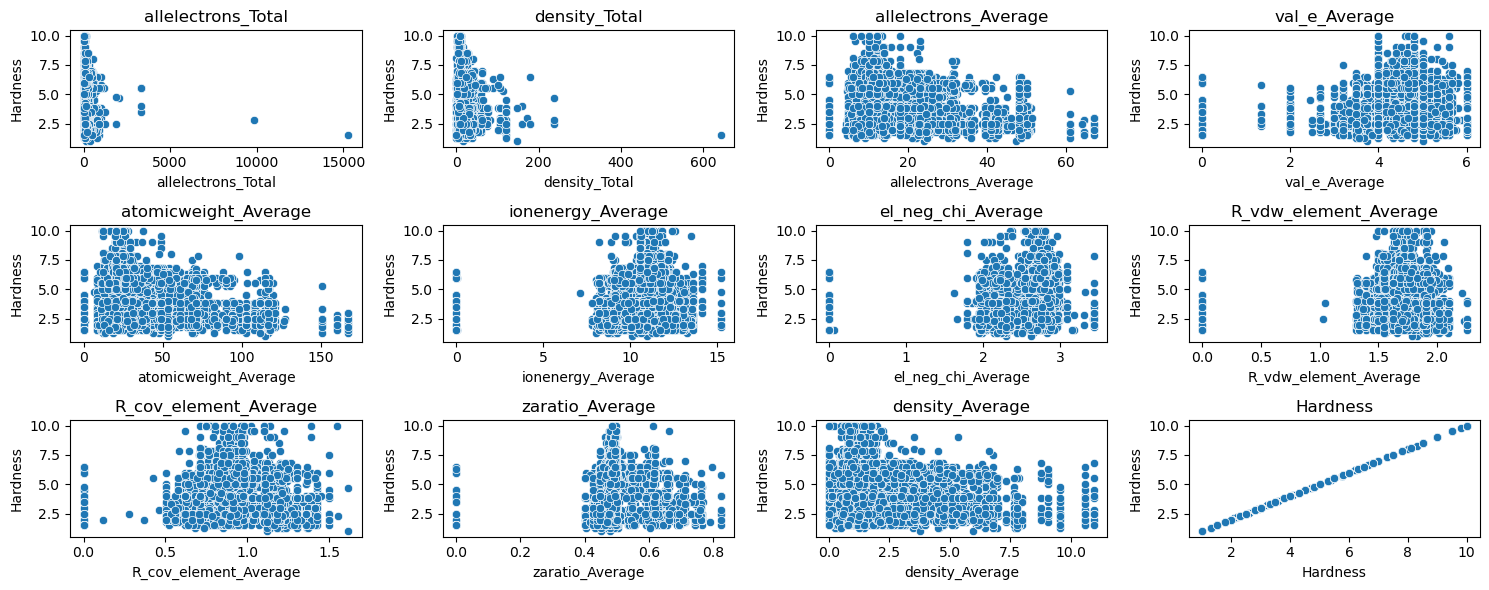

In [37]:
plt.figure(figsize = (15, 6))

for i in range(0, len(num_features)):
    plt.subplot(3, 4, i+1)
    plt.title(num_features[i])
    sns.scatterplot(data = df_train, x = num_features[i], y = target)

plt.tight_layout()

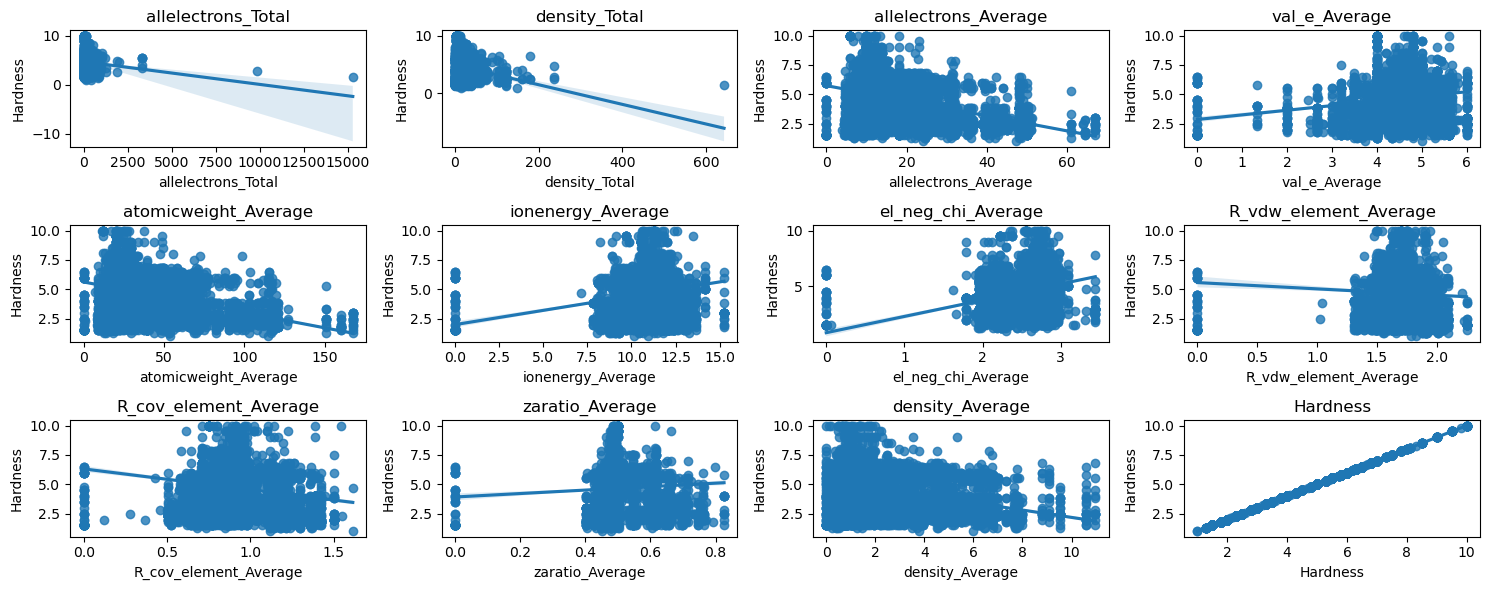

In [38]:
plt.figure(figsize = (15, 6))

for i in range(0, len(num_features)):
    plt.subplot(3, 4, i+1)
    plt.title(num_features[i])
    sns.regplot(data = df_train, x = num_features[i], y = target)

plt.tight_layout()

In [47]:
df_train['Hardness_cat'] = pd.cut(df_train[target], bins = [0, 3, 5.5, 7, 10,100], labels = ['0-3','3-5.5','5.5-7','7-10','10+'])

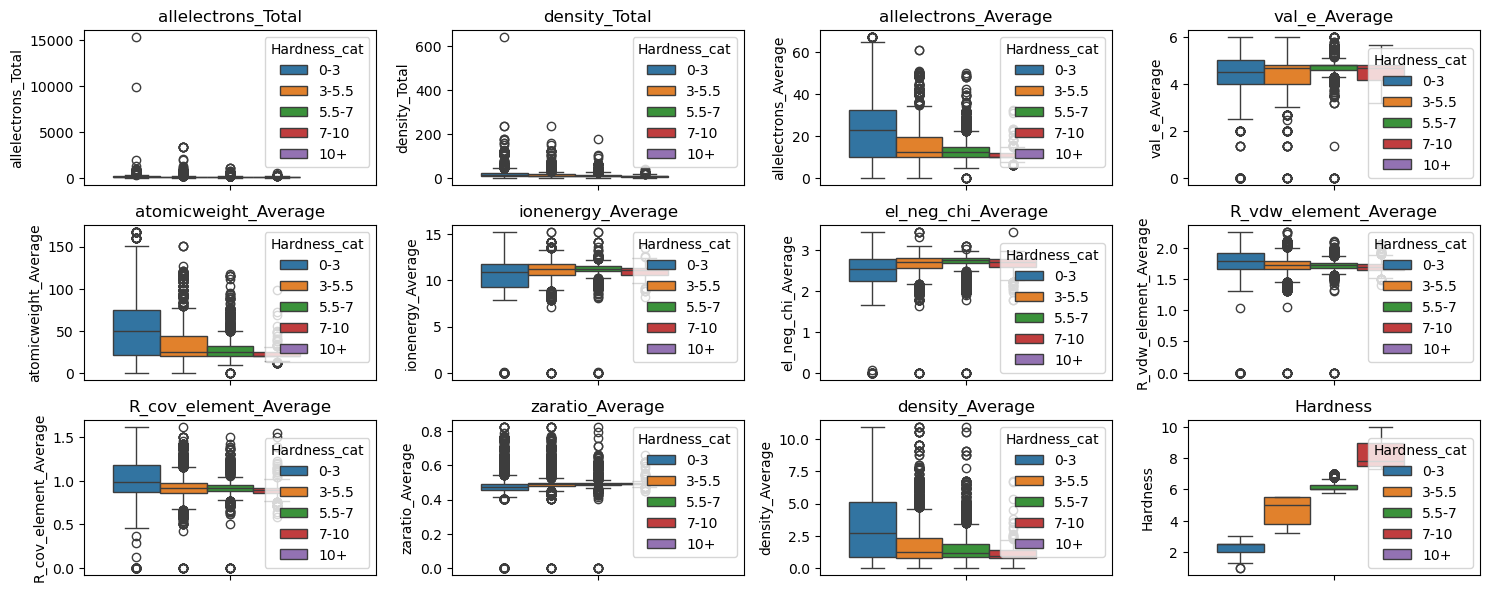

In [49]:
plt.figure(figsize = (15, 6))

for i in range(0, len(num_features)):
    plt.subplot(3, 4, i+1)
    plt.title(num_features[i])
    sns.boxplot(data = df_train, y = num_features[i], hue='Hardness_cat')

plt.tight_layout()

# Model Evaluation

## Train-test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 23)

## Linear Regression

In [67]:
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# cross-validation
result = cross_validate(model, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'neg_median_absolute_error')
-np.mean(result['test_score'])

0.9628345146147176

## XGBoost

In [68]:
model = XGBRegressor()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# cross-validation
result = cross_validate(model, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'neg_median_absolute_error')
-np.mean(result['test_score'])

0.6872006893157959

## Catboost

In [69]:
model = CatBoostRegressor()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# cross-validation
result = cross_validate(model, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'neg_median_absolute_error')
-np.mean(result['test_score'])

Learning rate set to 0.057227
0:	learn: 1.6427563	total: 149ms	remaining: 2m 28s
1:	learn: 1.6161995	total: 153ms	remaining: 1m 16s
2:	learn: 1.5885214	total: 156ms	remaining: 51.9s
3:	learn: 1.5657364	total: 160ms	remaining: 39.9s
4:	learn: 1.5442387	total: 164ms	remaining: 32.7s
5:	learn: 1.5249142	total: 169ms	remaining: 27.9s
6:	learn: 1.5060480	total: 173ms	remaining: 24.5s
7:	learn: 1.4884146	total: 177ms	remaining: 21.9s
8:	learn: 1.4732037	total: 181ms	remaining: 19.9s
9:	learn: 1.4590514	total: 185ms	remaining: 18.3s
10:	learn: 1.4459674	total: 191ms	remaining: 17.1s
11:	learn: 1.4332517	total: 196ms	remaining: 16.1s
12:	learn: 1.4218028	total: 201ms	remaining: 15.2s
13:	learn: 1.4117602	total: 206ms	remaining: 14.5s
14:	learn: 1.4020589	total: 210ms	remaining: 13.8s
15:	learn: 1.3930427	total: 214ms	remaining: 13.2s
16:	learn: 1.3850885	total: 219ms	remaining: 12.6s
17:	learn: 1.3776929	total: 223ms	remaining: 12.2s
18:	learn: 1.3703502	total: 227ms	remaining: 11.7s
19:	learn

0.6676408680629093

## Random Forest

In [71]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# cross-validation
result = cross_validate(model, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'neg_median_absolute_error')
-np.mean(result['test_score'])

0.6819000000000005

# Selection

In [72]:
model = CatBoostRegressor()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# cross-validation
result = cross_validate(model, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'neg_median_absolute_error')
-np.mean(result['test_score'])

Learning rate set to 0.057227
0:	learn: 1.6427563	total: 7.94ms	remaining: 7.93s
1:	learn: 1.6161995	total: 15.7ms	remaining: 7.84s
2:	learn: 1.5885214	total: 21.7ms	remaining: 7.22s
3:	learn: 1.5657364	total: 27ms	remaining: 6.73s
4:	learn: 1.5442387	total: 32ms	remaining: 6.37s
5:	learn: 1.5249142	total: 37.1ms	remaining: 6.14s
6:	learn: 1.5060480	total: 42.8ms	remaining: 6.06s
7:	learn: 1.4884146	total: 48.6ms	remaining: 6.02s
8:	learn: 1.4732037	total: 53ms	remaining: 5.83s
9:	learn: 1.4590514	total: 57.2ms	remaining: 5.67s
10:	learn: 1.4459674	total: 61.9ms	remaining: 5.57s
11:	learn: 1.4332517	total: 66.5ms	remaining: 5.48s
12:	learn: 1.4218028	total: 70.9ms	remaining: 5.38s
13:	learn: 1.4117602	total: 75.3ms	remaining: 5.3s
14:	learn: 1.4020589	total: 79.3ms	remaining: 5.21s
15:	learn: 1.3930427	total: 83.8ms	remaining: 5.15s
16:	learn: 1.3850885	total: 88.1ms	remaining: 5.09s
17:	learn: 1.3776929	total: 92.5ms	remaining: 5.04s
18:	learn: 1.3703502	total: 96.8ms	remaining: 5s
19

0.6676408680629093

In [77]:
df_test = pd.read_csv("data/test.csv")
ids = df_test['id']
df_test = df_test.drop('id', axis = 1)

In [79]:
y_pred = model.predict(df_test)

In [87]:
pred_df = pd.DataFrame(y_pred)
pred_df.columns = ['Hardness']
pd.concat([ids, pred_df], axis = 1).to_csv("submission_v1.csv", index = False)